## Нереляционные базы данных: проект

In [1]:
! pip install pymongo

You should consider upgrading via the 'c:\users\user\anaconda3\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'c:\users\user\anaconda3\python.exe -m pip install --upgrade pip' command.


In [1]:
import random
import pymongo
import requests

from pprint import pprint
from datetime import datetime

Требования к нереляционным БД: 

**2** - нереляционная БД  
**2** - красивая структура БД  
**2** - интерфейс позволяет класть, доставать, удалять данные (проводить операции CRUD - Create, Read, Update, Delete)  
**2** - два действия помимо CRUD (сортировка, группировка, агрегация, ...)  
**2** - MongoDB - работа с текстами или географией

### Описание базы данных

**Задача:** хранить комментарии из пабликов в ВК, которые я использую для дипломной работы по распознаванию токсичности

**Информация**, которую мне надо хранить: 
* исходные данные:
    * текст комментария
    * источник (айди и название паблика, айди автора, айди поста, айди комментария)
    * поставленные лайки
    * время публикации
* разметка:
    * токсичность (0/1)
    * наличие искажений слов (0/1)
    * исправленная версия (None/string)
    
**Алгоритм действий:**
1. Напарсить данные из ВК
2. Записать в базу
3. Провести классификацию, здесь - сымитировать её
4. Добавить в базу результаты классификации
5. Представить некоторые функции для анализа собранных данных

**Структура базы данных:**  
Три коллекции: *all_data* для всех данных, *uncorrected_dataset* и *corrected_dataset* для соответствующего варианта тестовых данных  

all_data содержит поля *text*, *source*, *likes*, *pub_time*  
после имитации разметки добавляются поля *toxicity*, *distortion*, *corrected*

uncorrected_dataset и corrected_dataset содержат поля *text* и *toxicity_label* - только нужные для обучения и тестирования моделей

### 1. Парсинг данных

In [2]:
class Comment:
    """Класс, содержащий все необходимые поля для одного комментария"""
    def __init__(self):
        self.text = ''
        self.source = {'group_name': '',
                       'group_id': '',
                       'post_id': '',
                       'author_id': '',
                       'comment_id': ''}
        self.likes = ''
        self.pub_time = ''

        self.toxicity = ''
        self.distortion = ''
        self.correction = ''
        
    def __repr__(self):
        return f"{self.text} - {self.source['group_name']}"


In [3]:
with open('vk_token.txt', encoding='UTF-8') as f:
    TOKEN = f.read()

In [4]:
def get_post_ids(group_id, n_posts):
    """Возвращает список айди постов заданного паблика"""
    post_ids = []
    for off in range(0, n_posts, 100):
        data = requests.get(
            'https://api.vk.com/method/wall.get', 
            params={
                "owner_id": group_id,
                "count": 100,
                "v":"5.131",
                "offset": off,
                "access_token": TOKEN
            }
        ).json()
        for item in data['response']['items']:
            post_ids.append(item['id'])
    return post_ids


def get_comment_texts(group_id, post_id_list):
    """По адресу группы и списку постов возвращает для каждого поста
       10 комментов и ответов, пока не наберётся 200"""
    comments = []
    for post_id in post_id_list:
        data = requests.get(
            'https://api.vk.com/method/wall.getComments', 
            params={
                "owner_id": group_id,
                "post_id": post_id,
                "preview_length": 0,
                "thread_items_count": 10, # max 10
                "count": 10, # def 10, max 100
                "extended": 1,
                "fiels": ['first_name', 'last_name', 'sex'],
                "need_likes": 1,
                "v":"5.131",
                "access_token": TOKEN
            }
        ).json()

        for item in data['response']['items']:
            if item['text']: # если есть текст, в т.ч. комментарий не удалён
                cur_comment = Comment()
                cur_comment.text = item['text']
                cur_comment.source = {'group_name': groups[group_id],
                                      'group_id': group_id,
                                      'post_id': post_id,
                                      'author_id': item['from_id'],
                                      'comment_id': item['id']}
                cur_comment.likes = item['likes']['count']
                cur_comment.pub_time = item['date']
                comments.append(cur_comment)

                if item['thread']['count'] > 0:
                    for reply_comment in item['thread']['items']:
                        rep_comment = Comment()
                        rep_comment.text = reply_comment['text']
                        rep_comment.source = {'group_name': groups[group_id],
                                              'group_id': group_id,
                                              'post_id': post_id,
                                              'author_id': reply_comment['from_id'],
                                              'comment_id': reply_comment['id']}
                        rep_comment.likes = reply_comment['likes']['count']
                        rep_comment.pub_time = reply_comment['date']
                        comments.append(rep_comment)
        if len(comments) > 200:
            break
    return comments[:200]

In [5]:
groups = {-76982440: 'meduza',
          -29534144: 'lentach',
          -17568841: 'dozhd'}

In [6]:
def parse_groups(groups):
    """Обходит все группы в переданном словаре"""
    comments = []
    for group_id in groups.keys():
        post_ids = get_post_ids(group_id, 100)
        post_comments = get_comment_texts(group_id, post_ids)
        comments.extend(post_comments)
    
    return comments

In [7]:
comments = parse_groups(groups)

In [8]:
len(comments)

600

In [9]:
comments[0]

пока ещё открывается. Может быть, от провайдера зависит - meduza

### 2. Записать в базу
#### Операции CRUD - create, read, update, delete
* создать базу  
* записать собранное в базу  
* проверить, что всё записалось корректно

**Создание** базы данных и коллекций:

In [10]:
with open('mongo_password.txt', encoding='UTF-8') as f:
    PASS = f.read()

In [11]:
client = pymongo.MongoClient('localhost', 27017)
db = client['disguised_toxicity']

In [12]:
db

Database(MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True), 'disguised_toxicity')

In [13]:
all_data = db.all_data
uncorrected_dataset = db.raw_data
corrected_dataset = db.corrected_data

**Запись** напаршенного в коллекцию all_data:

In [14]:
# удалить всё от предыдущих прогонов
all_data.delete_many({})
uncorrected_dataset.delete_many({})
corrected_dataset.delete_many({})

In [15]:
all_data.count_documents({})

0

In [16]:
def add_parsed_data(data_collection):
    """Вставляет в базу нужные атрибуты класса комментария"""
    parsed = data_collection.insert_many([{'text': comment.text,
                                           'source': comment.source,
                                           'likes': comment.likes,
                                           'pub_time': datetime.fromtimestamp(comment.pub_time)}
                                           for comment in comments])
    parsed_ids = parsed.inserted_ids
    return parsed_ids

In [17]:
parsed_ids = add_parsed_data(all_data)

Проверить, что все записались

In [18]:
all_data.count_documents({})

600

### 3. Сымитировать классификацию
* Проапдетить разметку

Функция производит **чтение** текстов из базы, обеспечивает их разметку и добавление исправленной версии /пока просто префикс CORRECTED_/

In [19]:
def labelling(collection):
    """Функция для проведения ручной разметки прям в тетрадке"""
    for item in collection.find():
        print(item['text'])
        toxicity_label = input('Токсичность: ')
        distortion_label = input('Искажение: ')
        if distortion_label:
            corrected_text = input('Исправленный текст')
        else:
            corrected_text = item['text']
            
        collection.find_one_and_update({'_id': item['_id']},
                                       {'$set': {'toxicity': toxicity_label,
                                                 'distortion': distortion_label,
                                                 'corrected': corrected_text}})

In [20]:
labelling(all_data)

пока ещё открывается. Может быть, от провайдера зависит
Токсичность: 0
Искажение: 0
Исправленный текст
[id412055656|Вадим], хреново как-то они блокирнули


KeyboardInterrupt: Interrupted by user

### 4. Добавить в базу результаты классификации
Такая же функция, но разметка сымитирована рандомом

In [21]:
def labelling_imitation(collection):
    for item in collection.find():
        toxicity_label = random.choices([0, 1], [0.78, 0.22], k=1)[0]
        distortion_label = random.choices([0, 1], [0.95, 0.05], k=1)[0]
        if distortion_label:
            corrected_text = 'CORRECTION_'+item['text']
        else:
            corrected_text = item['text']
            
        collection.find_one_and_update({'_id': item['_id']},
                                       {'$set': {'toxicity': toxicity_label,
                                                 'distortion': distortion_label,
                                                 'corrected': corrected_text}})

**Апдейт** информации в базе по результатам работы функции:

In [22]:
labelling_imitation(all_data)

Посмотреть, как сейчас выглядят данные:

In [23]:
pprint(all_data.find({})[0])

{'_id': ObjectId('624178fb3ecfd0488bd2b7d3'),
 'corrected': 'пока ещё открывается. Может быть, от провайдера зависит',
 'distortion': 0,
 'likes': 5,
 'pub_time': datetime.datetime(2022, 3, 4, 17, 26, 11),
 'source': {'author_id': 80034454,
            'comment_id': 5768876,
            'group_id': -76982440,
            'group_name': 'meduza',
            'post_id': 5768869},
 'text': 'пока ещё открывается. Может быть, от провайдера зависит',
 'toxicity': 0}


### 5. Представить некоторые функции для анализа собранных данных
#### Работа с текстом + удаление
После ручной разметки я поняла, что фильтра по [ ] на парсинге было недостаточно, надо **найти** и **удалить** комментарии, где нет ничего, кроме ссылки на топикстартера

In [24]:
def delete_unnecessary(collection):
    pattern = '\[.*\],$'
    query = {'text': {'$regex': pattern}}
    deleted = collection.delete_many(query)
    
    return f'Удалено записей: {deleted.deleted_count}'

In [25]:
delete_unnecessary(all_data)

'Удалено записей: 21'

### Создание подкорпусов
**Апдейт** коллекций *uncorrected_dataset* и *corrected_dataset*, в них из общей коллекции собираются только данные, нужные для тестирования модели

In [27]:
def create_corpora(sourse_col, uncorrected_col, corrected_col):
    uncorrected_ids = uncorrected_col.insert_many([{'text': item['text'],
                                                    'toxicity_label': item['toxicity']}
                                                   for item in sourse_col.find({'distortion': 1})])    
    corrected_ids = corrected_col.insert_many([{'text': item['corrected'],
                                                'toxicity_label': item['toxicity']}
                                               for item in sourse_col.find({'distortion': 1})])
    
    return uncorrected_ids, corrected_ids

In [28]:
uncorrected_ids, corrected_ids = create_corpora(all_data, uncorrected_dataset, corrected_dataset)

In [29]:
for uncorr, corr in zip(uncorrected_dataset.find({}), corrected_dataset.find({})):
    print(uncorr['text'], uncorr['toxicity_label'])
    print(corr['text'], corr['toxicity_label'], '\n')

если ты в Украине - скоро у вас будет вакуум. Как захватят до конца 0
CORRECTION_если ты в Украине - скоро у вас будет вакуум. Как захватят до конца 0 

[id2065649|Антон], здесь не почтовая служба Кремля... вы , наверное, перепуталии в спешке...
Кстати, за оскорбление президента рф вас могут привлечь...  например  , отправят на споп. 1
CORRECTION_[id2065649|Антон], здесь не почтовая служба Кремля... вы , наверное, перепуталии в спешке...
Кстати, за оскорбление президента рф вас могут привлечь...  например  , отправят на споп. 1 

Господи, ну и дегенерат, на Белоруссию глянь. И да, если английская маня думает, что Путин не будет стрелять в людей, то он очень ошибается.

Московская полиция может справиться с 30 тысячами людей на улицах города; может быть, с сотней тысяч. Если выйдет больше 300 тысяч, она будет ошеломлена. Придется использовать армию, но будет ли эта армия сражаться за Путина, когда дойдет до дела? 0
CORRECTION_Господи, ну и дегенерат, на Белоруссию глянь. И да, если англ

#### Помимо CRUD (сортировка, группировка, агрегация и тд)
Подсчитать все токсичные комментарии, все искажённые и пересечения токсичных и искажённых:

In [30]:
def count_toxic(collection):
    toxic_count = collection.aggregate([{'$group': {'_id': '$toxicity',
                                                    'count': {'$sum': 1}}},
                                        {'$project': {'_id': 0, 'is_toxic': '$_id',
                                                      'count': 1, 'sum': 1}}])
    return toxic_count

def count_distortion(collection):
    distortion_count = collection.aggregate([{'$group': {'_id': '$distortion',
                                                         'count': {'$sum': 1}}},
                                             {'$project': {'_id': 0, 'is_distorted': '$_id',
                                                           'count': 1, 'sum': 1}}]) 
    return distortion_count
    
def count_intersection(collection):
    intersection_count = all_data.aggregate([{'$match': {'toxicity': {'$eq': 1}, 'distortion': {'$eq': 1}}},
                                             {'$count': 'toxic + distorted count'}])
    return intersection_count

In [31]:
print('Подсчёт токсичных:')
for tc in count_toxic(all_data):
    print(tc)
print('\nПодсчёт искажённых:')
for dc in count_distortion(all_data):
    print(dc)
print('\nПересечение токсичных и искажённых:')
for ic in count_intersection(all_data):
    print(ic)

Подсчёт токсичных:
{'count': 460, 'is_toxic': 0}
{'count': 119, 'is_toxic': 1}

Подсчёт искажённых:
{'count': 553, 'is_distorted': 0}
{'count': 26, 'is_distorted': 1}

Пересечение токсичных и искажённых:
{'toxic + distorted count': 4}


Подсчитать среднее количество лайков комментариях из разных групп:

In [32]:
def count_mean_likes(collection):
    mean_likes = collection.aggregate([{'$group': {'_id': '$source.group_name',
                                                   'mean_likes': {'$avg': '$likes'}}},
                                       {'$project': {'_id': 0, 'group': '$_id',
                                                     'mean_likes': 1}}])
    return mean_likes

In [33]:
for ml in count_mean_likes(all_data):
    print(ml)

{'mean_likes': 5.3979591836734695, 'group': 'meduza'}
{'mean_likes': 21.896907216494846, 'group': 'lentach'}
{'mean_likes': 6.412698412698413, 'group': 'dozhd'}


Подсчитать среднюю токсичность у разных комментаторов - учитывать только тех, кто написал хотя бы 5 комментариев в любой из групп, вывести топ-6 самых токсичных в порядке убывания:

In [34]:
def count_mean_toxicity(collection):
    
    mean_tox = collection.aggregate([{'$group': {'_id': '$source.author_id',
                                                 'comment_count': {'$sum': 1},
                                                 'mean_toxicity': {'$avg': '$toxicity'}}},
                                     {'$match': {'comment_count': {'$gte': 5}}},
                                     {'$project': {'_id': 0, 'author': '$_id', 
                                                   'mean_toxicity': {'$round': ['$mean_toxicity', 2]}}},
                                     {'$sort': {'mean_toxicity': -1}},
                                     {'$limit': 6}])
    return mean_tox

In [35]:
for mt in count_mean_toxicity(all_data):
    print(mt)

{'author': 645959071, 'mean_toxicity': 0.45}
{'author': 692715088, 'mean_toxicity': 0.4}
{'author': 319349643, 'mean_toxicity': 0.4}
{'author': 706564314, 'mean_toxicity': 0.4}
{'author': 7882860, 'mean_toxicity': 0.4}
{'author': 2065649, 'mean_toxicity': 0.29}


Вывести график распределения комментариев по времени публикации (единица - день):

In [36]:
import matplotlib.pyplot as plt
import matplotlib.dates
import numpy as np

def plot_time_distribution(collection): 
    time_dist = collection.aggregate([{'$group': {'_id': {'$dayOfYear': '$pub_time'},
                                                  'n_comments': {'$sum': 1}}}])
    x_values = []
    y_values = []

    for td in time_dist:
        x_values.append(datetime.strptime('2022'+'-'+str(td['_id']), '%Y-%j').date())
        y_values.append(td['n_comments'])
        
    fig, ax = plt.subplots(figsize=(20, 4))
    dates = matplotlib.dates.date2num(x_values)
    ax.plot_date(dates, y_values)
    plt.xticks(rotation=40)
    ax.xaxis.set_major_locator(matplotlib.dates.DayLocator())
    plt.show()

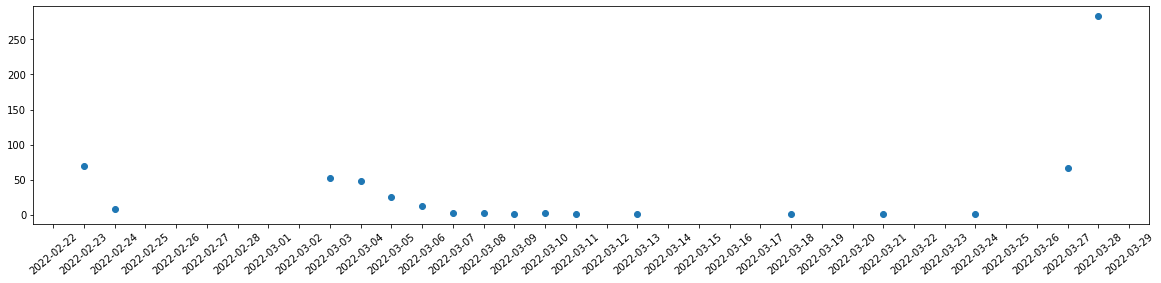

In [37]:
plot_time_distribution(all_data)

### Работа с текстом
Создание индекса для поиска:

In [38]:
all_data.create_index([('text', 'text')])

'text_text'

Строгий и нестрогий поиск заданных вхождений с указанным словом в поле текста комментария, сортировка от новых к старым либо по скору:

In [40]:
def search_any(collection, query, top_n, sort='date'):
    if sort == 'score':
        result = collection.find({'$text': {'$search': query}},
                                 {'score': {'$meta': 'textScore'}})
        result.sort([('score', {'$meta': 'textScore'})]).limit(top_n)
    else:
        result = collection.find({'$text': {'$search': query}}).sort('date', pymongo.DESCENDING).limit(top_n)
    return result

def search_all(collection, query, top_n, sort='date'):
    if sort == 'score':
        result = collection.find({'$text': {'$search': f'\"{query}\"'}},
                                 {'score': {'$meta': 'textScore'}})
        result.sort([('score', {'$meta': 'textScore'})]).limit(top_n)
    else:
        result = collection.find({'$text': {'$search': f'\"{query}\"'}}).sort('date', pymongo.DESCENDING).limit(top_n)

    return result

In [41]:
for r in search_any(all_data, 'дурак тупой', 5, 'score'):
    pprint(r)
    print('\n')

{'_id': ObjectId('624178fb3ecfd0488bd2b937'),
 'corrected': '[id256116|Igor], дурак?',
 'distortion': 0,
 'likes': 0,
 'pub_time': datetime.datetime(2022, 3, 28, 11, 22, 46),
 'score': 0.6666666666666666,
 'source': {'author_id': 22527227,
            'comment_id': 17124055,
            'group_id': -29534144,
            'group_name': 'lentach',
            'post_id': 17123821},
 'text': '[id256116|Igor], дурак?',
 'toxicity': 0}


{'_id': ObjectId('624178fb3ecfd0488bd2b850'),
 'corrected': '[id179392072|Valery], я дурак',
 'distortion': 0,
 'likes': 0,
 'pub_time': datetime.datetime(2022, 3, 27, 22, 48, 36),
 'score': 0.625,
 'source': {'author_id': 537561782,
            'comment_id': 5810682,
            'group_id': -76982440,
            'group_name': 'meduza',
            'post_id': 5810651},
 'text': '[id179392072|Valery], я дурак',
 'toxicity': 0}


{'_id': ObjectId('624178fb3ecfd0488bd2b831'),
 'corrected': '[id370015658|Иван], вы тупой или прикидываетесь за копеечку?',
 'disto

In [42]:
for r in search_all(all_data, 'дурак тупой', 5, 'date'):
    pprint(r)
    print('\n')

In [43]:
for r in search_all(all_data, 'ты дурак', 5, 'date'):
    pprint(r)
    print('\n')

Модифицированный запрос из прошлого пункта: встречаемость слова или слов из запроса в токсичных и нетоксичных текстах

In [44]:
def search_by_toxicity(collection, query, find='any'):
    if find == 'all':
        query = f'\"{query}\"'

    toxic_count = collection.aggregate([{'$match': {'$text': {'$search': query}}},
                                        {'$group': {'_id': '$toxicity',
                                                    'count': {'$sum': 1}}},
                                        {'$project': {'_id': 0, 'is_toxic': '$_id',
                                                      'count': 1, 'sum': 1}}])
    return toxic_count

In [45]:
for res in search_by_toxicity(all_data, 'ты дурак', find='any'):
    pprint(res)

{'count': 11, 'is_toxic': 1}
{'count': 45, 'is_toxic': 0}
